## Brief description of the problem and data
Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. If homes can be found for them, many precious lives can be saved — and more happy families created.<br>
For this project create an algorithm that can predict the adoptability (only and not how fast unlike the original requirements of the competition) of pets using Deep Learning. The algorithm could help identify animals with lower adoption prospects, enabling targeted care interventions to enhance their chances of finding a home.

### Git Repo
Link: https://github.com/Lenni-A/Deep_Learning/tree/main/week6

### Data
Source data: https://www.kaggle.com/competitions/petfinder-adoption-prediction/data

The data available in Kaggle include many sets of files including text, tabular and image files. The training data has many info based on the pet’s listing on PetFinder, including profile which sometimes represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted. For this project not all files are used, below are the details on these:

#### File descriptions
- train.csv - Tabular/text data for the training set
- test.csv - Tabular/text data for the test set

#### Data Fields
- PetID - Unique hash ID of pet profile
- AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
- Type - Type of animal (1 = Dog, 2 = Cat)
- Name - Name of pet (Empty if not named)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
- Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Quantity - Number of pets represented in profile
- Fee - Adoption fee (0 = Free)
- State - State location in Malaysia (Refer to StateLabels dictionary)
- RescuerID - Unique hash ID of rescuer
- VideoAmt - Total uploaded videos for this pet
- PhotoAmt - Total uploaded photos for this pet
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

#### AdoptionSpeed
Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:
- 0 - Pet was adopted on the same day as it was listed.
- 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
- 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
- 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

#### Images
For pets that have photos, they will be named in the format of PetID-ImageNumber.jpg. Image 1 is the profile (default) photo set for the pet.<br>
For privacy purposes, faces, phone numbers and emails have been masked.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import resnet50

In [2]:
# Test and intialize GPU / TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except Exception as e:
    print("Unable to initialize tpu, using default. Exception: " + str(e))
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.experimental.AUTOTUNE

Unable to initialize tpu, using default. Exception: Please provide a TPU Name to connect to.
Number of replicas: 1


In [3]:
# Set paths and datasets / dataframes needed
path_train_data = './data/train/'
path_train_imgs = './data/train_images/'
path_test_data = './data/test/'
path_test_imgs = './data/test_images/'
print("Train image count: ", len(os.listdir(path_train_imgs)),"\n")
df_train_full = pd.read_csv(os.path.join(path_train_data, 'train.csv'))
df_train_full.info()
print(df_train_full.head(5))
print("\nTest image count: ", len(os.listdir(path_test_imgs)))
df_test = pd.read_csv(os.path.join(path_test_data, 'test.csv'))

Train image count:  58311 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 n

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
Show a few visualizations like histograms. Describe any data cleaning procedures.<br><br>
For this project the model will only be trained for adopted or not adopted. In order to do this a new field needs to be created that helps identifies this based on AdoptionSpeed.<br>
Additionally based on the dataframe info above make sure there are no gaps in the PetID which is relevant to load the image file and remove all pet records which have no image(s) associated.<br>
With these precautions and pre-processing all relevant fields are then clean.

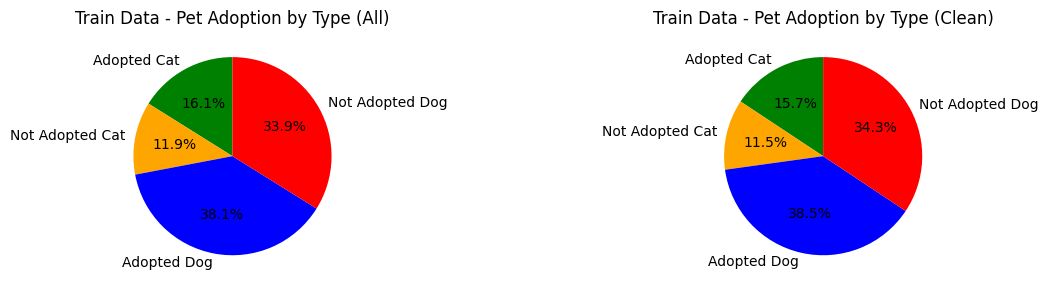

In [4]:
# Create a new field that helps identifies adopted or not adopted based on AdoptionSpeed.
df_train_full['Adopted'] = np.where(df_train_full['AdoptionSpeed'] == 4, 0, 1)
# Plot pets based on adoption status
labels_all = df_train_full.groupby(['Adopted', 'Type']).size().unstack(fill_value=0).stack().values
df_train_clean = df_train_full[df_train_full['PhotoAmt'] != 0]
labels_clean = df_train_clean.groupby(['Adopted', 'Type']).size().unstack(fill_value=0).stack().values
adopted_labels = ['Adopted Cat', 'Not Adopted Cat', 'Adopted Dog', 'Not Adopted Dog']

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].pie(labels_all, labels=adopted_labels, autopct='%1.1f%%', startangle=90, colors=['green', 'orange', 'blue', 'red'])
axes[0].set_title('Train Data - Pet Adoption by Type (All)')
axes[1].pie(labels_clean, labels=adopted_labels, autopct='%1.1f%%', startangle=90, colors=['green', 'orange', 'blue', 'red'])
axes[1].set_title('Train Data - Pet Adoption by Type (Clean)')
plt.tight_layout()
plt.show()

Show 10 random images for each adopted and not adopted pets.

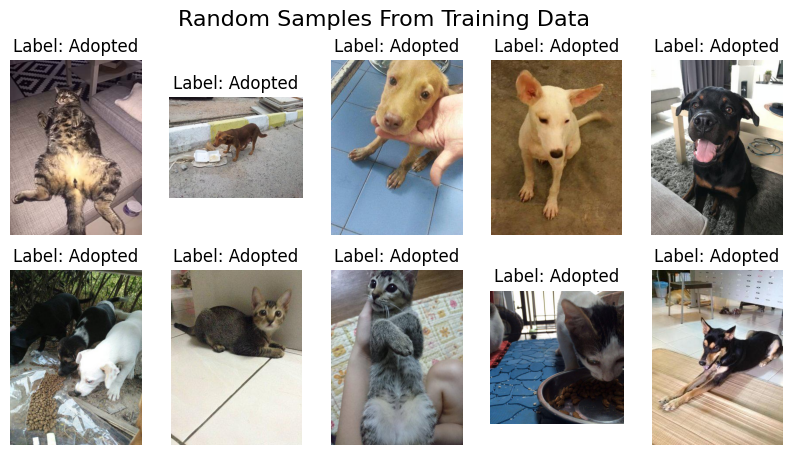

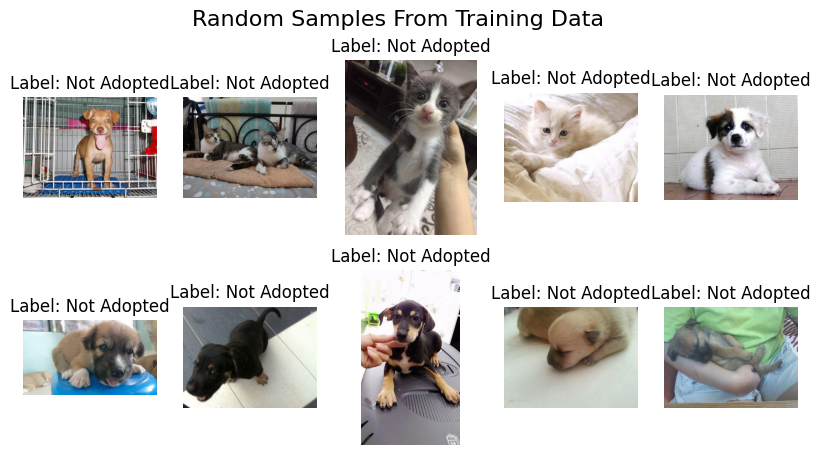

In [5]:
img_cnt = 10
# Create list of adopted and not adopted pet images
adopted_imgs = df_train_clean[df_train_clean['Adopted'] == 0]['PetID'].values
not_adopted_imgs = df_train_clean[df_train_clean['Adopted'] == 1]['PetID'].values

# Plot 10 random images for adopted and not adopted pets
fig, axs = plt.subplots(2, img_cnt // 2, figsize=(10, 5))
label = 'Adopted'
for ax in axs.ravel():
    pet_id = np.random.choice(adopted_imgs)
    file_img = os.path.join(path_train_imgs, f'{pet_id}-1.jpg')
    img = image.imread(file_img)
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('Random Samples From Training Data', fontsize=16)
plt.show()

label = 'Not Adopted'
fig, axs = plt.subplots(2, img_cnt // 2, figsize=(10, 5))
for ax in axs.ravel():
    pet_id = np.random.choice(not_adopted_imgs)
    file_img = os.path.join(path_train_imgs, f'{pet_id}-1.jpg')
    img = image.imread(file_img)
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('Random Samples From Training Data', fontsize=16)
plt.show()

## DModel Architecture
Describe model architecture and reasoning for why that specific architecture would be suitable for this problem.

### Create training and validation datasets
Create training and validation datasets with 80 / 20 proportions from the original training data. And from the datasets create training and validation data holding the loaded image data which is simplified using grayscale (1 dimension) only.

In [6]:
def load_and_preproc_images(file_paths, img_size):
    imgs = []
    for fp in file_paths:
        img = load_img(fp, target_size=img_size, color_mode='grayscale')
        img_array = img_to_array(img)
        imgs.append(img_array)
    return np.array(imgs)

img_files = [os.path.join(path_train_imgs, f"{pet_id}-1.jpg") for pet_id in df_train_clean['PetID']]
img_size = (128, 128)
labels = df_train_clean['Adopted']

# Split the data into training and validation sets
X_train_imgf, X_valid_imgf, y_train, y_valid = train_test_split(img_files, labels, test_size=0.2, random_state=42)
X_train = load_and_preproc_images(X_train_imgf, img_size)
X_valid = load_and_preproc_images(X_valid_imgf, img_size)

### Create Model
Use CNN which is very suitable for image recognition. Unlike my previous submission using CNN and starting setup of 1 set of conv layer (3 per set) with 16 filters, MaxPool and Dropout, for this task a classical CNN architecture called VGG (in particular VGG19) will be used. It is developed to increase the model performance which is true as it surpassed my previous CNN implementations. There are VGG19 implementations and pre-trained models available online but these are not flexible for the task and use more resources for training thus the implementation of the model below is 'manual', replicating the VGG19 structure.<br><br>
** As stated above the image data is only 1 dimesion (grayscale) which is necessary in order to run the training on normal devices and not run into out of memory (OOM) issue. 

In [8]:
def create_model_VGG19(filter_count:int = 128, img_size:int = 128):
    kernel_size = (3,3)
    pool_size= (2,2)
    activation_relu = 'relu'
    activation_sigm = 'sigmoid'

    model = Sequential()
    model.add(Conv2D(input_shape=(img_size, img_size, 1), filters=filter_count/2, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count/2, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(MaxPooling2D(pool_size = pool_size))

    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(MaxPooling2D(pool_size = pool_size))

    filter_count *= 2
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(MaxPooling2D(pool_size = pool_size))

    filter_count *= 2
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(MaxPooling2D(pool_size = pool_size))

    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, padding="same", activation=activation_relu))
    model.add(MaxPooling2D(pool_size = pool_size))

    model.add(Flatten())
    model.add(Dense(4096, activation = activation_relu))
    model.add(Dense(4096, activation = activation_relu))
    model.add(Dense(1, activation = activation_sigm))
    model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Create different models with different filters and batch sizes.
model_trained = None
best_acc = 0
model_count = 3
filter_count = 32
batch_size = 8
epoch = 5
epoch_steps = 10

for x in range(model_count):
    print(f'\n----- CREATING MODEL {x} (Filters: {filter_count} / Batch Size: {batch_size})-----')
    model = create_model_VGG19(filter_count)
    model.summary()
    print('----- TRAINING MODEL -----')
    mt = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=epoch, 
        steps_per_epoch=epoch_steps, 
        batch_size=batch_size)
    acc = np.mean(mt.history['accuracy'])
    print(f'MEAN ACCURACY: {acc}')
    if acc > best_acc:
        best_acc = acc
        model_trained = mt
    batch_size *= 2
    filter_count *= 2


----- CREATING MODEL 0 (Filters: 32 / Batch Size: 8)-----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0       

## Results and Analysis
Based on the training output, the VGG19 model trained for 5 epochs with a batch size of 8 and 32 filters achieves a mean accuracy of approx. 61%, but the validation loss and accuracy show inconsistency, suggesting a potential issue such as overfitting or insufficient training data. Fine tune this model with different hyperparameters to achieve a higher accuracy.

In [13]:
filter_count = 32
model = create_model_VGG19(filter_count)
model.summary()
best_acc = 0
model_trained = None
df = pd.DataFrame(columns=['Epoch', 'Epoch_Step', 'Batch_Size', 'Loss', 'Acc'])

epochs = [50, 100, 500, 1000]
epoch_steps = [10, 20, 30, 50]
batch_sizes = [8, 8, 16, 16]
for i, epoch in enumerate(epochs):
    print(epoch, epoch_steps[i])
    print('----- TRAINING MODEL -----')
    mt = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=epoch, 
        steps_per_epoch=epoch_steps[i], 
        batch_size=batch_sizes[i])
    acc = np.mean(mt.history['accuracy'])
    loss = np.mean(mt.history['loss'])
    print(f'MEAN ACCURACY: {acc}')
    if acc > best_acc:
        best_acc = acc
        model_trained = mt
    df.loc[len(df)] = [epoch, epoch_steps[i], batch_sizes[i], loss, acc]
print(df)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 conv2d_65 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 conv2d_67 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                 

#### Measurement
Plot the training result of the best model which has the lowest epoch for Loss and Accuracy.

Looking at the calculation logs and the stats, it seems the model is not learning effectively as the loss and accuracy values on both the training and validation sets are not improving. The loss values and the accuracy remain constant at approx. 73% throughout the epochs, suggesting that the model does not significantly improve over time and might be stuck in a local minimum or there might be an issue with the data or model architecture. Additionally the chosen hyperparameters might not be optimal for this task eg. the relatively small batch size of 8 may be limiting the model's ability to generalize effectively thus it could be worth experimenting with different hyperparameter settings or model architectures.

    Epoch  Epoch_Step  Batch_Size         Loss       Acc
0    50.0        10.0         8.0  7777.206288  0.707750
1   100.0        20.0         8.0     0.591008  0.725056
2   500.0        30.0        16.0     0.586624  0.727342
3  1000.0        50.0        16.0     0.586080  0.727470


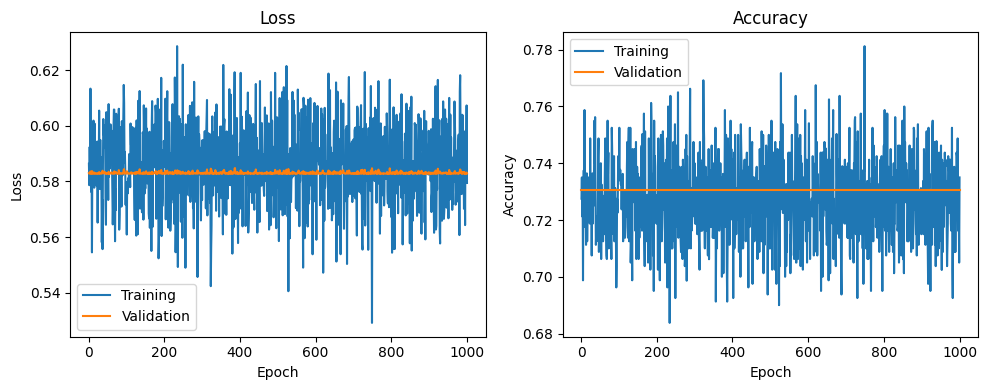

In [14]:
print(df.head())

def plot_metrics(history, metrics):
    epoch_cnt = range(1, len(history[metrics[0]]) + 1)
    metrics_cnt = len(metrics)
    plt.figure(figsize=(10, 4))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, metrics_cnt, i)
        plt.plot(epoch_cnt, history[metric], label='Training')
        plt.plot(epoch_cnt, history[f'val_{metric}'], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.title(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(model_trained.history, ['loss', 'accuracy'])

#### Trained model with test data
Use the trained model with test data. Save result for Kaggle submission.

In [26]:
df_test_clean = df_test[df_test['PhotoAmt'] != 0]
test_img_files = [os.path.join(path_test_imgs, f"{pet_id}-1.jpg") for pet_id in df_test_clean['PetID']]
X_test = load_and_preproc_images(test_img_files, img_size)
pred_values = model_trained.model.predict_generator(X_test, verbose=1)
file_names = [os.path.splitext(os.path.basename(file))[0] for file in test_img_files]
df_submission = pd.DataFrame({'PetID': file_names, 'AdoptionSpeed': np.argmax(pred_values, axis=1) })
# df_submission['PetID'] = df_submission['PetID'].apply(lambda x: x.split('.')[0])
df_submission.to_csv('pet_finder_submission.csv', index=False)

e:\Learn\_Code_\3_Introduction to Deep Learning\.venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


121/121 [==============================] - 7s 61ms/step


## Conclusion
The created VGG19 model with a total of 26,430,705 parameters is trained on a dataset of approx. 14,650 primary images using the Adam optimizer and binary cross-entropy loss function. It's classical architecture includes multiple convolutional and pooling layers, followed by 3 dense layers which should provide the approriate setup to identify a high amount of the images correctly. However, it seems that the model's performance seems to plateau and is not learning effectively from the given data. It's possible that the chosen hyperparameters, eg. such as the number of filters and batch size are not suitable for the given dataset.

To enhance the model several improvements could be explored such as hyperparameter tuning, trying different architectures and consideration of other regularization techniques. Additionally, experimenting with different optimizers or learning rate schedules may achieve better stability and performance during training.